# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import os
import zipfile
import datetime
from PIL import Image
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# Download Dataset

In [2]:
# Mendownload dataset tomato dari kaggle
! kaggle datasets download -d kaustubhb999/tomatoleaf

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 93% 166M/179M [00:00<00:00, 282MB/s]
100% 179M/179M [00:00<00:00, 270MB/s]


# Extract Dataset

In [3]:
# Tentukan path ke file zip dataset
zip_path = 'tomatoleaf.zip'

# Tempat direktori untuk mengekstrak dataset
extract_path = ''

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define Dataset Paths

In [4]:
# Path ke direktori dataset tomato
path_dataset = "tomato/"
train_dir ="tomato/train/"
val_dir = "tomato/val/"

In [5]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_size, val_size):
    classes = os.listdir(source_dir)

    train_counts = {}
    val_counts = {}
    test_counts = {}

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = os.listdir(cls_path)
        np.random.shuffle(images)

        train_split = int(len(images) * train_size)
        val_split = int(len(images) * val_size)

        train_images = images[:train_split]
        val_images = images[train_split:train_split + val_split]
        test_images = images[train_split + val_split:]

        # Create directories if not exist
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # Move images
        for img in train_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

        for img in val_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

        for img in test_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

        # Count images
        train_counts[cls] = len(train_images)
        val_counts[cls] = len(val_images)
        test_counts[cls] = len(test_images)

    return train_counts, val_counts, test_counts

# Directories
source_dir = 'tomato/train'
train_dir = 'tomato_split/train'
val_dir = 'tomato_split/validation'
test_dir = 'tomato_split/test'

# Split ratios
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Split the data and get counts
train_counts, val_counts, test_counts = split_data(source_dir, train_dir, val_dir, test_dir, train_size, val_size)

# Display counts
print("Training set:")
for cls, count in train_counts.items():
    print(f"Class {cls}: {count} images")

print("\nValidation set:")
for cls, count in val_counts.items():
    print(f"Class {cls}: {count} images")

print("\nTest set:")
for cls, count in test_counts.items():
    print(f"Class {cls}: {count} images")


Training set:
Class Tomato___Septoria_leaf_spot: 800 images
Class Tomato___Target_Spot: 800 images
Class Tomato___Late_blight: 800 images
Class Tomato___Early_blight: 800 images
Class Tomato___Spider_mites Two-spotted_spider_mite: 800 images
Class Tomato___Tomato_Yellow_Leaf_Curl_Virus: 800 images
Class Tomato___Tomato_mosaic_virus: 800 images
Class Tomato___Bacterial_spot: 800 images
Class Tomato___Leaf_Mold: 800 images
Class Tomato___healthy: 800 images

Validation set:
Class Tomato___Septoria_leaf_spot: 100 images
Class Tomato___Target_Spot: 100 images
Class Tomato___Late_blight: 100 images
Class Tomato___Early_blight: 100 images
Class Tomato___Spider_mites Two-spotted_spider_mite: 100 images
Class Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100 images
Class Tomato___Tomato_mosaic_virus: 100 images
Class Tomato___Bacterial_spot: 100 images
Class Tomato___Leaf_Mold: 100 images
Class Tomato___healthy: 100 images

Test set:
Class Tomato___Septoria_leaf_spot: 100 images
Class Tomato___Targe

In [6]:
def resize_images(input_dir, output_dir, target_size):
    # Loop through each class directory
    for tomato_type in os.listdir(input_dir):
        input_dataset_dir = os.path.join(input_dir, tomato_type)
        output_dataset_dir = os.path.join(output_dir, tomato_type)

        if not os.path.exists(output_dataset_dir):
            os.makedirs(output_dataset_dir)

        # Loop through each image in the class directory
        for tomato_filename in os.listdir(input_dataset_dir):
            input_images_path = os.path.join(input_dataset_dir, tomato_filename)
            output_images_path = os.path.join(output_dataset_dir, tomato_filename)

            # Check if the file is a directory
            if os.path.isfile(input_images_path):
                img = Image.open(input_images_path)
                resized_image = img.resize(target_size)
                resized_image.save(output_images_path)

# Example usage
input_dir = "tomato_split/train"
output_dir = "tomato_fix/train"
target_size = (224, 224)

resize_images(input_dir, output_dir, target_size)
print("Resizing images to 224 x 224 pixels completed.")

Resizing images to 224 x 224 pixels completed.


In [7]:
def resize_images(input_dir, output_dir, target_size):
    # Loop through each class directory
    for tomato_type in os.listdir(input_dir):
        input_dataset_dir = os.path.join(input_dir, tomato_type)
        output_dataset_dir = os.path.join(output_dir, tomato_type)

        if not os.path.exists(output_dataset_dir):
            os.makedirs(output_dataset_dir)

        # Loop through each image in the class directory
        for tomato_filename in os.listdir(input_dataset_dir):
            input_images_path = os.path.join(input_dataset_dir, tomato_filename)
            output_images_path = os.path.join(output_dataset_dir, tomato_filename)

            # Check if the file is a directory
            if os.path.isfile(input_images_path):
                img = Image.open(input_images_path)
                resized_image = img.resize(target_size)
                resized_image.save(output_images_path)

# Example usage
input_dir = "tomato_split/validation"
output_dir = "tomato_fix/val"
target_size = (224, 224)

resize_images(input_dir, output_dir, target_size)
print("Resizing images to 224 x 224 pixels completed.")

Resizing images to 224 x 224 pixels completed.


In [8]:
def resize_images(input_dir, output_dir, target_size):
    # Loop through each class directory
    for tomato_type in os.listdir(input_dir):
        input_dataset_dir = os.path.join(input_dir, tomato_type)
        output_dataset_dir = os.path.join(output_dir, tomato_type)

        if not os.path.exists(output_dataset_dir):
            os.makedirs(output_dataset_dir)

        # Loop through each image in the class directory
        for tomato_filename in os.listdir(input_dataset_dir):
            input_images_path = os.path.join(input_dataset_dir, tomato_filename)
            output_images_path = os.path.join(output_dataset_dir, tomato_filename)

            # Check if the file is a directory
            if os.path.isfile(input_images_path):
                img = Image.open(input_images_path)
                resized_image = img.resize(target_size)
                resized_image.save(output_images_path)

# Example usage
input_dir = "tomato_split/test"
output_dir = "tomato_fix/test"
target_size = (224, 224)

resize_images(input_dir, output_dir, target_size)
print("Resizing images to 224 x 224 pixels completed.")

Resizing images to 224 x 224 pixels completed.


# Data Augmentation

In [9]:
# Path ke direktori dataset tomato
path_dataset = "tomato_dataset/"
train_dir ="tomato_fix/train/"
val_dir = "tomato_fix/val/"
test_dir = "tomato_fix/test/"

# Image Size
image_size = (224, 224)

# Define the image data generator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

# Validation data generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

# Test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


# Bulid Modelling

In [10]:
input_shape = (224, 224, 3)

In [11]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=input_shape)
# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable=False

# Add custom layers on top of the base model
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=prediction)

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.75, min_lr=0.00001)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile And Train Model

In [14]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=["accuracy"]
)


# Fit the model
vgg16_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    epochs=25,
    callbacks=[learning_rate_reduction, early_stopping],
    validation_steps=len(validation_generator),
    verbose=1
)

Epoch 1/25
250/250 [==============================] - 135s 491ms/step - loss: 1.3465 - accuracy: 0.5691 - val_loss: 0.7495 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 2/25
250/250 [==============================] - 113s 450ms/step - loss: 0.7351 - accuracy: 0.7535 - val_loss: 0.5840 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 3/25
250/250 [==============================] - 113s 454ms/step - loss: 0.5916 - accuracy: 0.8020 - val_loss: 0.4746 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 4/25
250/250 [==============================] - 115s 459ms/step - loss: 0.5042 - accuracy: 0.8280 - val_loss: 0.4385 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 5/25
250/250 [==============================] - 120s 479ms/step - loss: 0.4192 - accuracy: 0.8510 - val_loss: 0.4927 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 6/25
250/250 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8709
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
250/250 [========================

In [15]:
def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

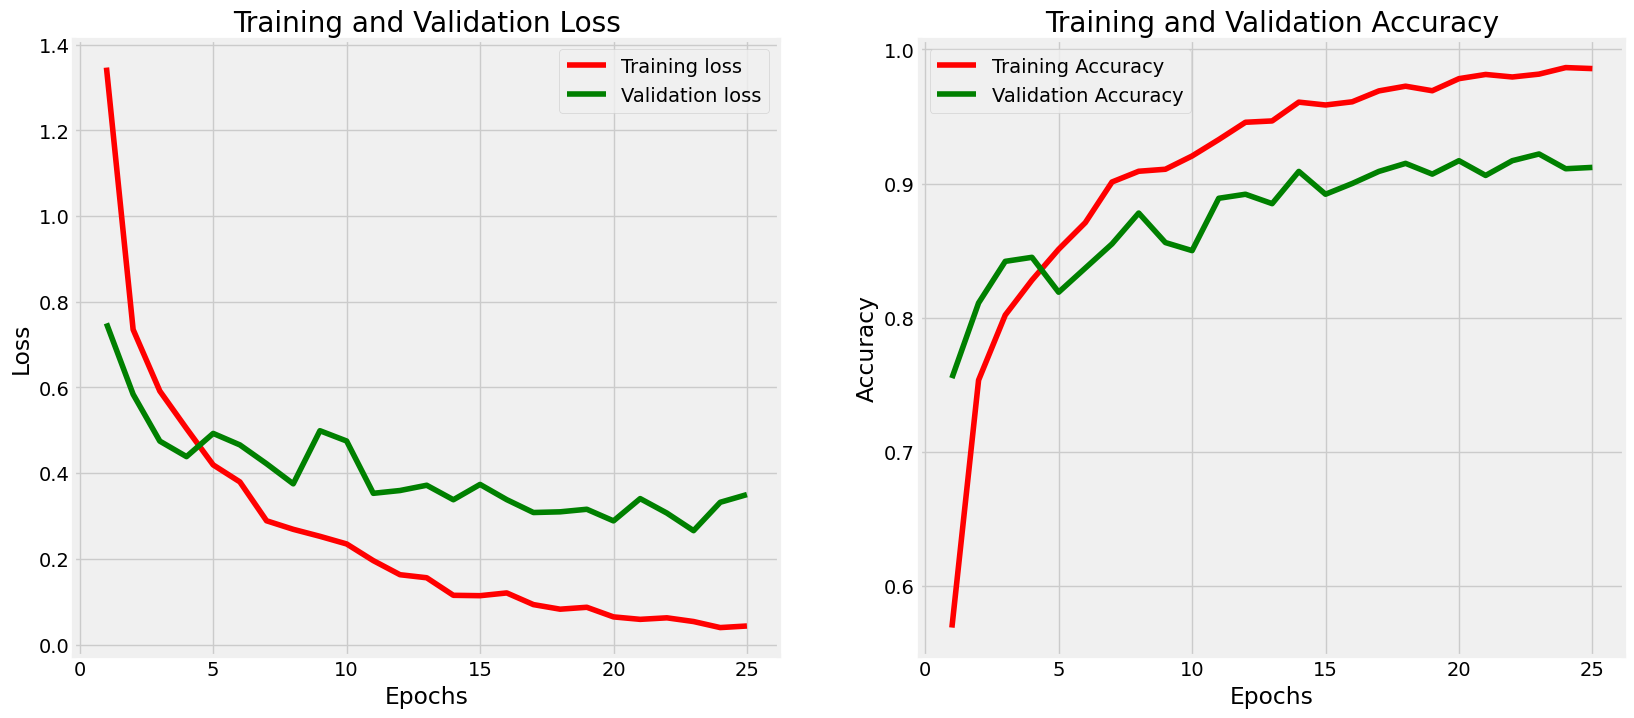

In [16]:
model_performance(vgg16_history)

In [17]:
def model_evaluation(model):
    train_score = model.evaluate(train_generator, verbose= 1)
    valid_score = model.evaluate(validation_generator, verbose= 1)
    test_score = model.evaluate(test_generator, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [18]:
model_evaluation(vgg16_model)

32/32 [==============================] - 5s 139ms/step - loss: 0.3452 - accuracy: 0.9110
Train Loss:  0.031451694667339325
Train Accuracy:  0.9893749952316284
--------------------
Validation Loss:  0.33534643054008484
Validation Accuracy:  0.9169999957084656
--------------------
Test Loss:  0.34522294998168945
Test Accuracy:  0.9110000133514404


# Testing

In [20]:
# Prediksi kelas dari data uji
predictions = vgg16_model.predict(test_generator)

# Dapatkan label sebenarnya dari data uji
true_labels = test_generator.classes

# Ubah prediksi dari one-hot encoding ke kelas tunggal
predicted_labels = np.argmax(predictions, axis=1)

# Buat confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix
print("Confusion Matrix VGG16:")
print(conf_matrix)

# Tampilkan laporan klasifikasi
print("\nClassification Report VGG16:")
print(classification_report(true_labels, predicted_labels))

32/32 [==============================] - 5s 142ms/step
Confusion Matrix VGG16:
[[ 93   1   2   0   0   0   4   0   0   0]
 [  2  73   3   4   3   4   9   1   1   0]
 [  0   2  84   5   2   2   5   0   0   0]
 [  0   1   0  91   0   2   0   1   5   0]
 [  1   0   0   3  94   0   1   0   1   0]
 [  0   0   0   0   1  96   2   0   1   0]
 [  0   0   1   0   1   6  92   0   0   0]
 [  0   1   0   1   0   1   0  97   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   1   0   0   3   5   0   0  91]]

Classification Report VGG16:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       100
           1       0.94      0.73      0.82       100
           2       0.92      0.84      0.88       100
           3       0.88      0.91      0.89       100
           4       0.93      0.94      0.94       100
           5       0.84      0.96      0.90       100
           6       0.78      0.92      0.84       100
           7       0.98    

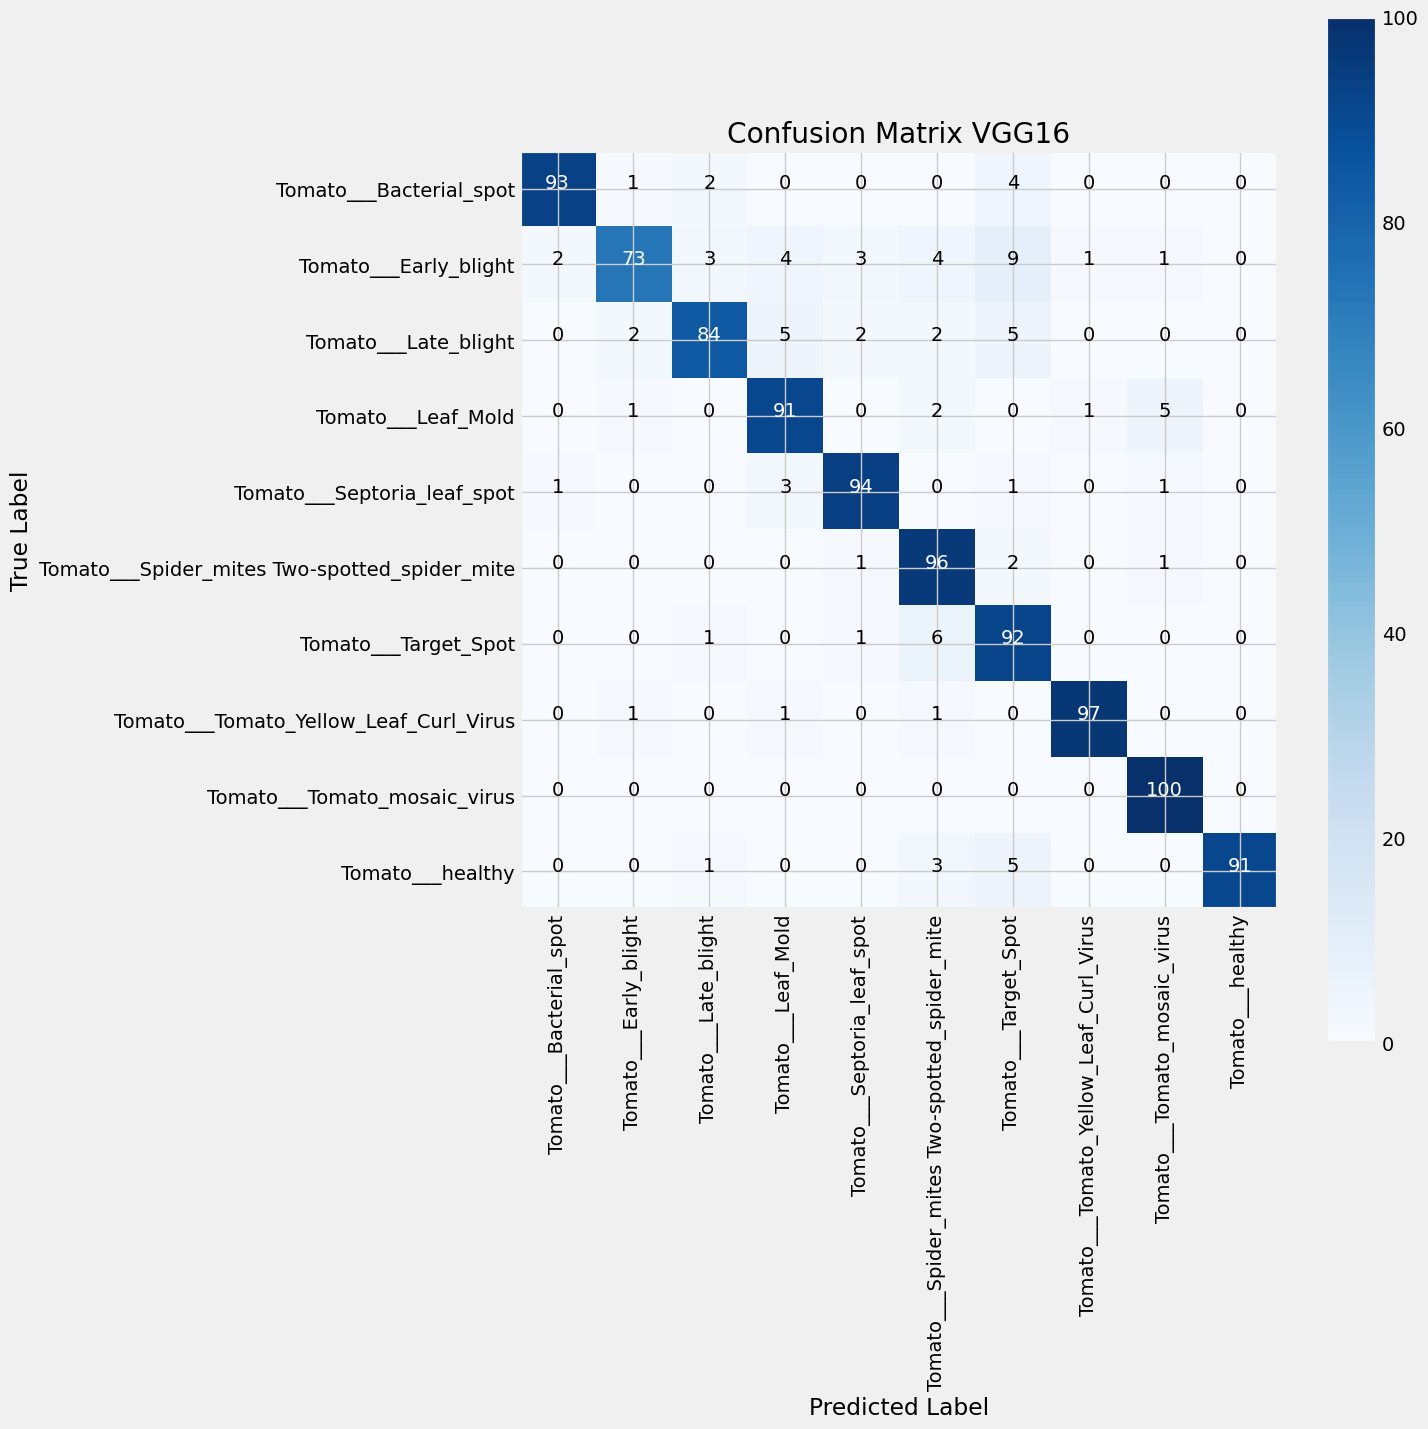

In [22]:
# Plot confusion matrix
plt.figure(figsize=(15, 15))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix VGG16')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Annotate confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
plt.savefig('confusion_matrix_VGG16.png')
plt.tight_layout()
plt.show()

In [24]:
class_names = list(train_generator.class_indices.keys())
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


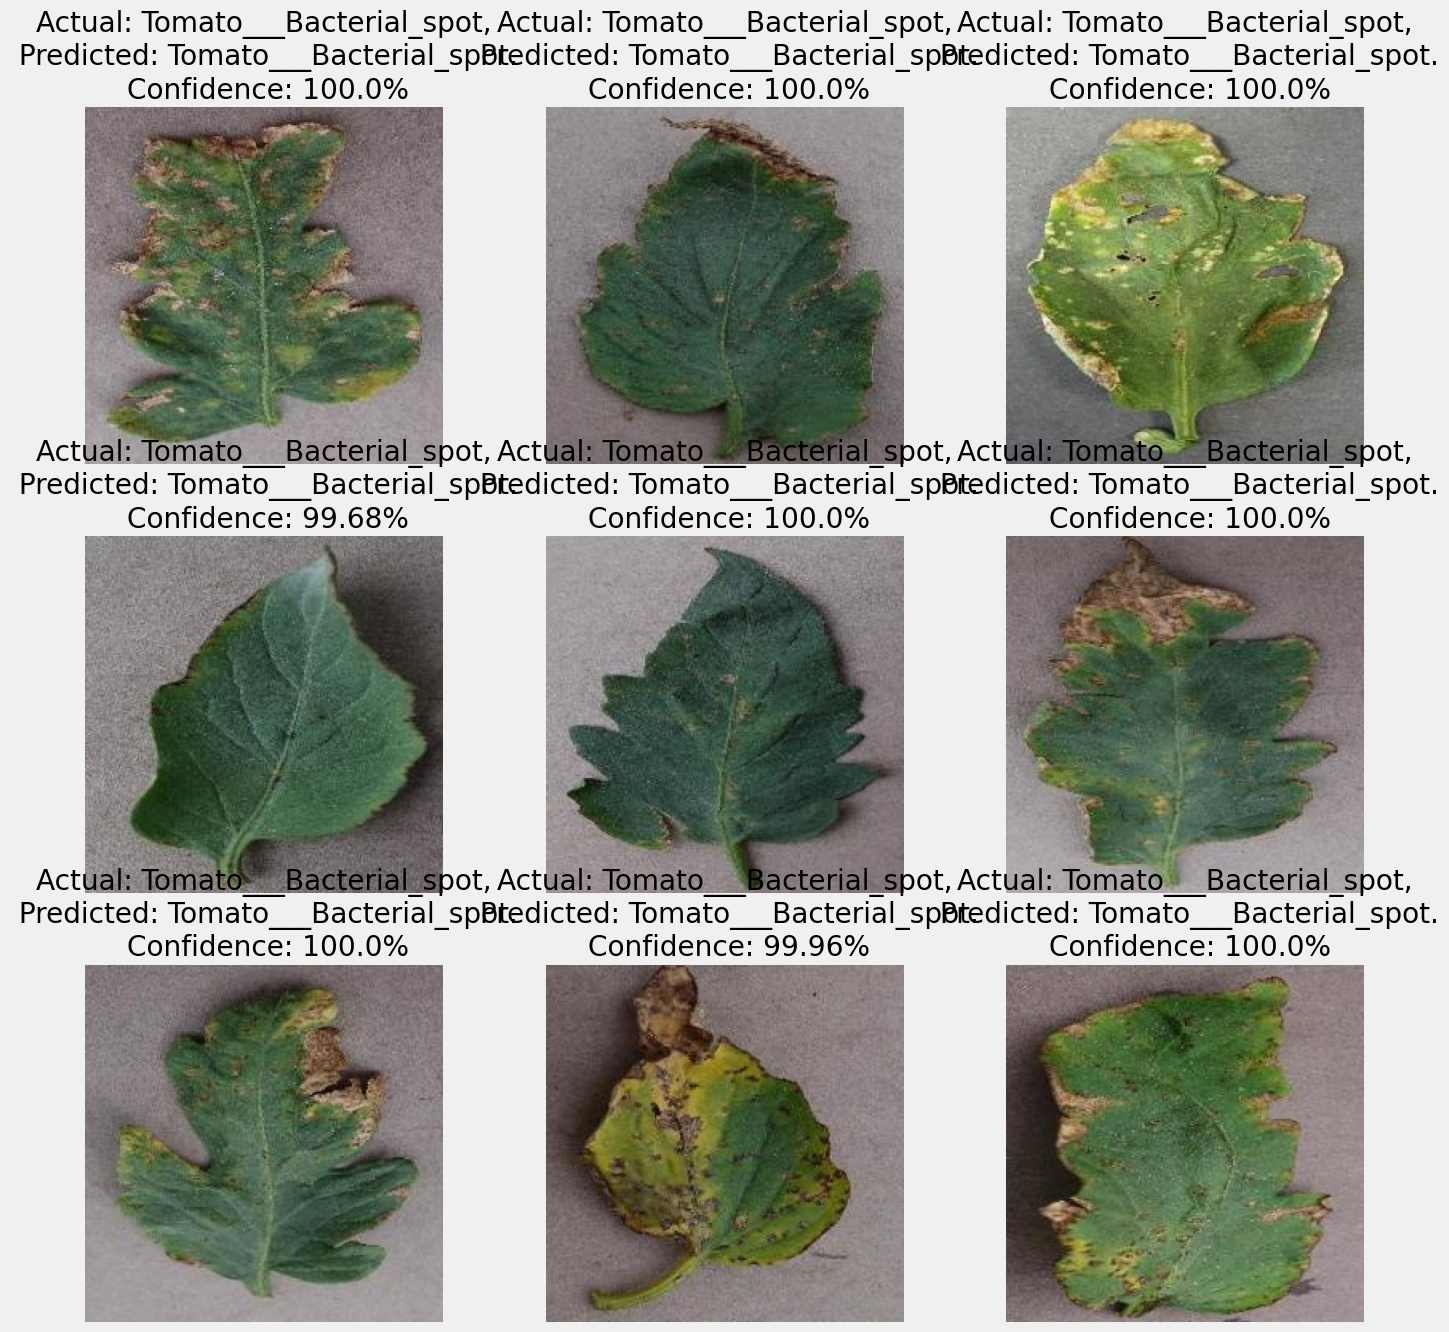

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(vgg16_model, images[i])
        index = labels[i].argmax(axis=0)
        actual_class = class_names[index]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

# Save Model

In [27]:
# Assuming your model object is called 'model'
vgg16_model.save(f"tomato_model_vgg16_{datetime.datetime.now().strftime('%d-%m')}.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
